Предметная область: образ жизни студентов  
Источник данных: https://www.kaggle.com/datasets/steve1215rogg/student-lifestyle-dataset  
Характер данных: Реальные  

Атрибуты датасета:
- Student_ID (int64)
- Study_Hours_Per_Day (float64)
- Extracurricular_Hours_Per_Day (Часы внеучебной деятельнсти) (float64)
- Sleep_Hours_Per_Day (float64)
- Social_Hours_Per_Day (float64)
- Physical_Activity_Hours_Per_Day (float64)
- Stress_Level (object)
- GPA (Средний балл) (float64)

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [38]:
df = pd.read_csv(r'data/student_lifestyle_clean.csv')
df

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,6.9,3.8,8.7,2.8,1.8,2.99,1
1,5.3,3.5,8.0,4.2,3.0,2.75,0
2,5.1,3.9,9.2,1.2,4.6,2.67,0
3,6.5,2.1,7.2,1.7,6.5,2.88,1
4,8.1,0.6,6.5,2.2,6.6,3.51,2
...,...,...,...,...,...,...,...
1995,6.5,0.2,7.4,2.1,7.8,3.32,1
1996,6.3,2.8,8.8,1.5,4.6,2.65,1
1997,6.2,0.0,6.2,0.8,10.8,3.14,1
1998,8.1,0.7,7.6,3.5,4.1,3.04,2


С помощью стандартного отклонения (метод Z-score) определим выбросы. 

In [39]:
# Считаем Z-оценку, устанавливаем порог = 3.
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
threshold = 3

# Находим индексы выбросов
pd.options.mode.chained_assignment = None
outliers = np.where(z_scores > threshold)
print('Выбросы:')
df_outliers = df.iloc[outliers[0]]
df_outliers['Outlier'] = df.columns[outliers[1]]
df_outliers

Выбросы:


,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level,Outlier
62,5.1,0.5,5.2,0.2,13.0,2.85,2,Physical_Activity_Hours_Per_Day
171,5.1,0.3,6.0,0.2,12.4,2.70,0,Physical_Activity_Hours_Per_Day
784,5.1,0.3,6.3,0.2,12.1,2.55,0,Physical_Activity_Hours_Per_Day
1174,5.3,0.3,5.9,0.2,12.3,2.97,2,Physical_Activity_Hours_Per_Day


Нашлись четыре выброса по физической активности, которые так же были замечены на графиках в первой работе, удалим их.

In [40]:
df = df.drop(df_outliers.index)
df.shape

(1996, 7)

Добавим новый атрибут на основе среднего балла. Из вещественного типа GPA получим целочисленные категории (0 (низкий балл), 1 (средний балл), 2 (высокий балл)).

In [41]:
df['Performance'] = round(df['GPA'])
df.drop('GPA', axis=1, inplace=True)
df.sample(5)

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,Stress_Level,Performance
603,7.2,2.6,9.7,0.3,4.2,1,3.0
449,5.1,1.7,6.5,2.9,7.8,0,3.0
1127,7.2,3.1,6.1,1.0,6.6,1,3.0
356,8.0,2.0,6.5,3.4,4.1,1,3.0
38,8.2,0.3,5.8,5.4,4.3,2,3.0


Построим матрицу графиков зависимостей между атрибутами.

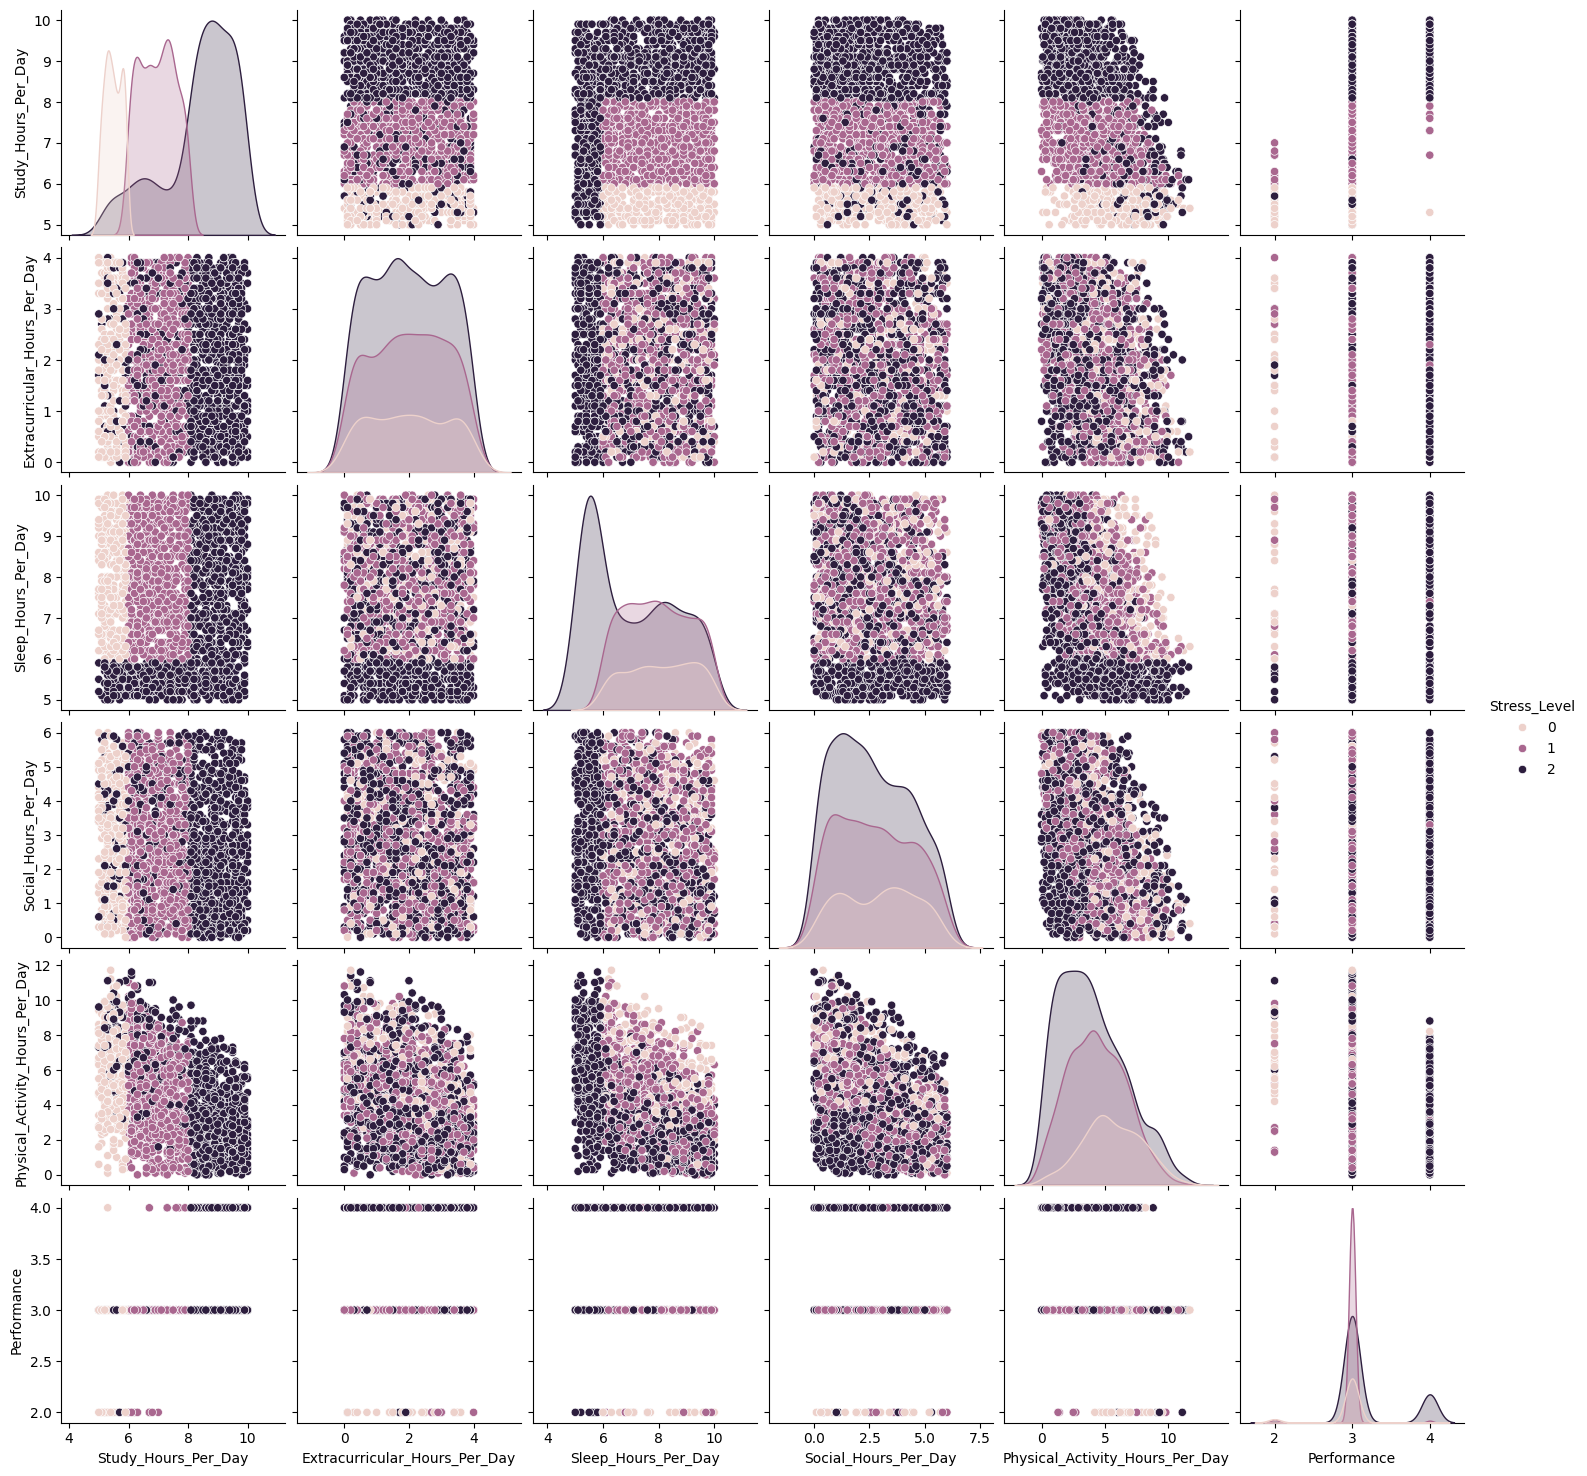

In [42]:
pplt = sns.pairplot(df, hue='Stress_Level')
# plt.show()

Как и в первой работе, видно, что уровень стресса сильно зависит от:
- Продолжительности обучения в день;
- Количества сна.  

Можно выделить категории студентов по количеству сна и обучения в день:
1. Спят больше 6 часов и мало занимаются - нет стресса;
2. Спят больше 6 часов и много занимаются - умеренный стресс;
3. Спят менее 6 часов и много занимаются - высокий стресс.

Найдём кластеры с помощью метода k-means.

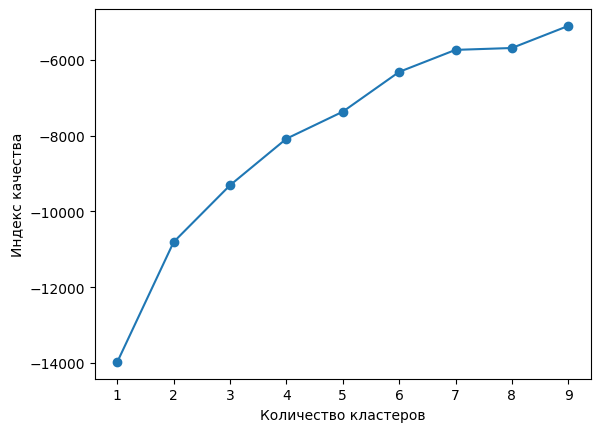

In [43]:
# Нормализация.
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Подбор числа k.
k_range = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in k_range]
scores = [kmeans[i-1].fit(df_scaled).score(df_scaled) for i in k_range]

# Отображение зависимости оценки от количества кластеров.
plt.plot(k_range, scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Индекс качества')
plt.show()

In [44]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=2372)
kmeans.fit(df_scaled)
labels = kmeans.predict(df_scaled)
df['Cluster'] = labels
print(
    f'Распределение кластеров:\n{df["Cluster"].value_counts()}\n'
    f'Итераций K-means: {kmeans.n_iter_}\n'
    f'Инерция: {round(kmeans.inertia_, 2)}'
)
df.sample(5)

Распределение кластеров:
Cluster
2    894
1    882
0    220
Name: count, dtype: int64
Итераций K-means: 19
Инерция: 9312.14


,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,Stress_Level,Performance,Cluster
592,5.0,1.7,5.5,4.5,7.3,2,3.0,1
1682,6.2,3.5,5.1,4.4,4.8,2,3.0,2
1396,7.4,2.8,5.3,1.2,7.3,2,3.0,1
915,5.5,3.8,5.3,1.8,7.6,2,3.0,1
1620,6.6,1.0,9.8,5.5,1.1,1,3.0,2


Посмотрим на распределение значений атрибутов в каждом кластере.

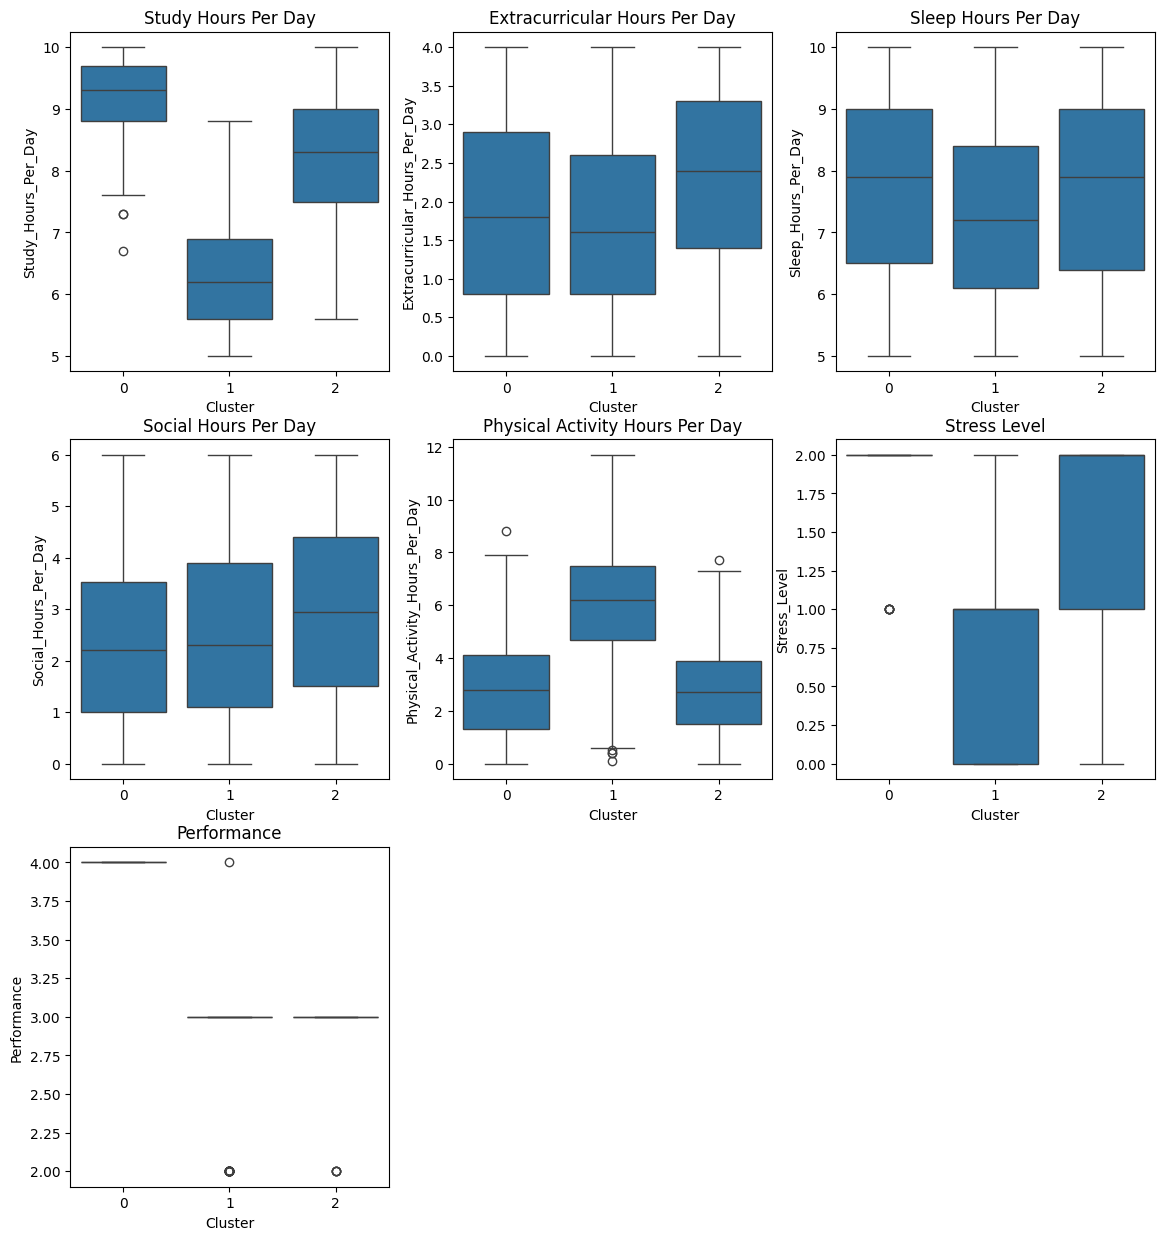

In [45]:
cols = df.columns[:-1]
cols_n = len(cols)
plt.figure(figsize=(14, 15))
for i in range(cols_n):
    col = cols[i]
    mean_value = df.groupby('Cluster')[col].mean()
    plt.subplot(ceil(cols_n / 3), 3, i + 1)
    sns.boxplot(data=df, x='Cluster', y=col)
    plt.title(col.replace('_', ' '))
    plt.xticks(range(0, 3))
plt.show()

Из графиков распределения видно, что кластеризация привела к разбиению на три группы:
- 0 = Высокий уровень стресса;
- 1 = Умеренный/низкий уровень;
- 2 = Умеренный/высокий уровень.

Выводы:
1. Из графика Physical_Activity_Hours_Per_Day видно, что занятия спортом качественно снижают уровень испытываемого стресса;
2. Social_Hours_Per_Day не имеет сильного влияния на уровень стресса, но заметно, что как избыточное, так и слишком низкое число социальных взаимодействий может повышать стресс;
3. Наиболее хорошая успеваемость наблюдается у студентов с высоким уровнем стресса, но есть исключения;
4. Подтверждается прямая зависимость между длительностью обучения, уровнем стресса и успеваемостью;
